In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

This is the method we followed to clean up the images.
1. We took the *phase* image 
2. Converted it to grayscale
3. Increased the contrast.


<Figure size 640x480 with 0 Axes>

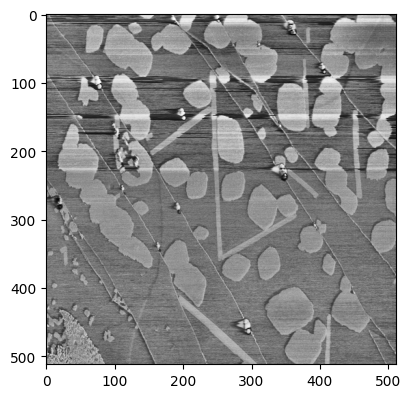

In [3]:
# PREPROCESSING 

# Read the image
image = cv2.imread('D:\\Pranav\\Pictures\\Saved Pictures\\1_amplitude.jpg')
image2 = cv2.imread('D:\\Pranav\\Pictures\\Saved Pictures\\1_phase.jpg ')

# Convert the image to grayscale
gray_amp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_phase = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

# histogram equalisation (increases contrast)
#equalized_image_phase = cv2.equalizeHist(gray_phase)

#CLAHE (Contrast Limited Adaptive Histogram Equalization) is another way to increase contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized_image_phase = clahe.apply(gray_phase)

4. First approach
* Remove the line noise 
* Apply thresholding 

5. Second approach
* Use K means clustering on contrasted phase image to extract useful items.

C:\Users\Pranav\AppData\Local\Temp\ipykernel_18116\3603780590.py:21: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum_no_horizontal = 20*np.log(np.abs(fshift))


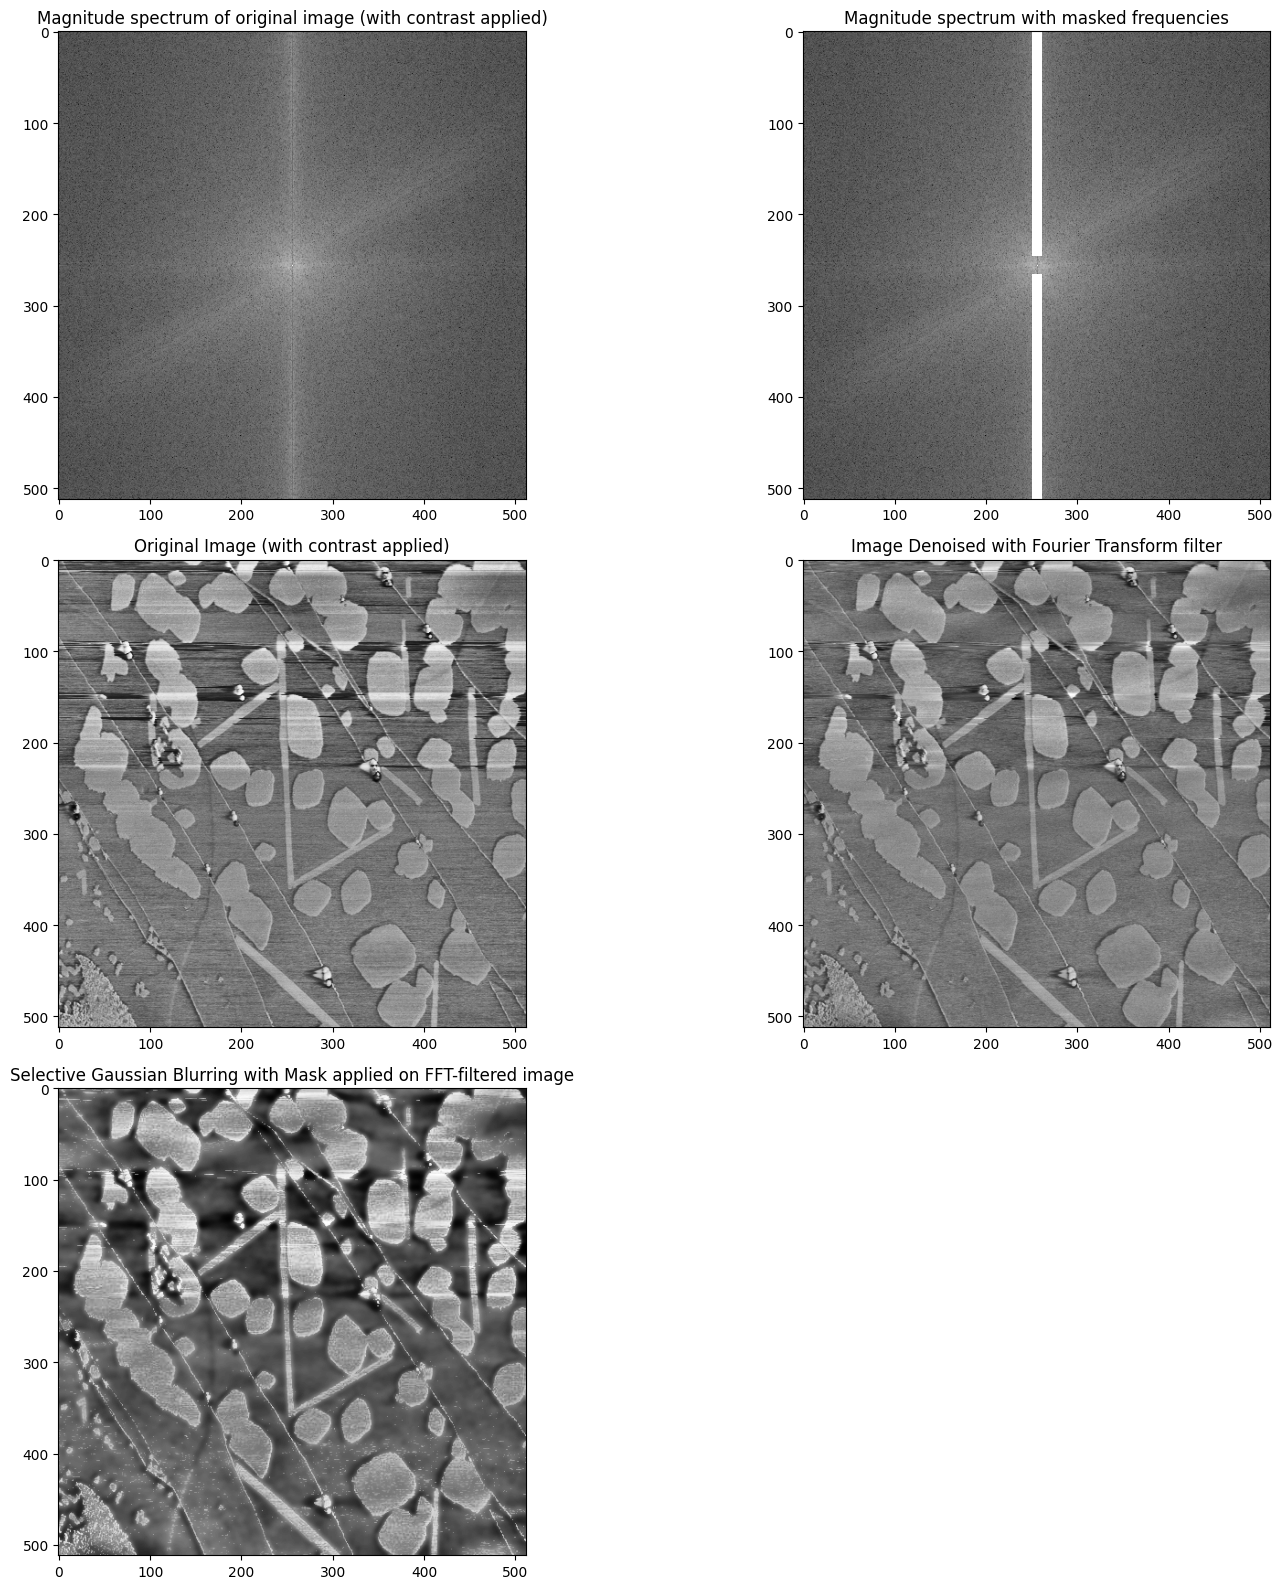

In [74]:
# reduce line noise
plt.figure(figsize=(16,16))

# Fourier transform
f = np.fft.fft2(equalized_image_phase)

#shift image to the center
fshift = np.fft.fftshift(f)

#display the log of the magnitude of the fourier transform
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.subplot(3,2,1)
plt.imshow(magnitude_spectrum)
plt.title("Magnitude spectrum of original image (with contrast applied)")

#create a frequency mask to remove line noise
rows, cols = equalized_image_phase.shape
crow,ccol = rows//2 , cols//2
fshift[0:crow-10, ccol-5:ccol+5] = 0
fshift[crow+10:, ccol-5:ccol+5] = 0
magnitude_spectrum_no_horizontal = 20*np.log(np.abs(fshift))
plt.subplot(3,2,2)
plt.imshow(magnitude_spectrum_no_horizontal)
plt.title("Magnitude spectrum with masked frequencies")

# get the spatial domain back
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)

plt.subplot(3,2,3)
plt.title("Original Image (with contrast applied)")
plt.imshow(equalized_image_phase)

plt.subplot(3,2,4)
plt.imshow(img_back)
plt.title("Image Denoised with Fourier Transform filter")
plt.imsave('./image.jpg', img_back)
denoise = cv2.imread('./image.jpg')


# FAILED BILATERAL FILTERING APPROACH

# plt.subplot(3,2,4)
# plt.imshow(cv2.bilateralFilter(equalized_image_phase, 6, 75, 75))
# plt.title("Using bilateral noise ")


#Creating a mask to apply selective filtering to the original filter
mask2 = np.zeros_like(denoise)
denoise = cv2.cvtColor(denoise, cv2.COLOR_RGB2GRAY)


# FAILED EDGE DETECTION APPROACH

#denoise = cv2.equalizeHist(gray_phase)
# blurred_image = cv2.medianBlur(denoise, 3)
# plt.imshow(blurred_image)
# canny = cv2.Canny(blurred_image, 75,100, apertureSize=3)

# Threshold the image to create a binary mask to apply selective filtering to.
_, thresholded = cv2.threshold(denoise, 130, 255, cv2.THRESH_BINARY)


# FAILED EDGE DETECTION APPROACH #2

# cont, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(mask2, cont, -1,(255,255,255),-1)

# use Gaussian blur to create a strongly blurred copy of the denoised image
blurred_image = cv2.GaussianBlur(denoise, (15, 15), 0)
result = np.where(thresholded!=0, denoise, blurred_image)
plt.subplot(3,2,5)
plt.imshow(clahe.apply(result), cmap="YlOrBr")
plt.title("Selective Gaussian Blurring with Mask applied on FFT-filtered image")

plt.tight_layout()
plt.show()

In [5]:
# Clustering
img = np.array(equalized_image_phase)
clusters, _ = cv2.kmeans(img, 16, None, cv2.TERM_CRITERIA_COUNT, 10, cv2.KMEANS_RANDOM_CENTERS)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'kmeans'
> Overload resolution failed:
>  - Can't parse 'criteria' as TermCriteria.Input argument doesn't provide sequence protocol
>  - Can't parse 'criteria' as TermCriteria.Input argument doesn't provide sequence protocol
